In [3]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 3.9 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

### **READING EXCEL FILES**

In [6]:
holiday = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/holidays_events.csv')
oil =  pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/stores.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/transactions.csv')
train = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/train.csv')


### **MERGING FILES**

In [7]:
df_1 = pd.merge(train,oil,on = 'date',how = 'left')
df_2 = pd.merge(df_1,holiday,on = 'date', how = 'left')
df_3 = pd.merge(df_2,stores, on = 'store_nbr', how = 'left')
df = pd.merge(df_3,transactions, on = ['date','store_nbr'], how = 'left')

### **CHECK FOR MISSING VALUES**

In [8]:
df.isnull().sum()


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
dcoilwtico       955152
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
city                  0
state                 0
type_y                0
cluster               0
transactions     249117
dtype: int64

### **REPLACE MISSING VALUES IN OIL PRICE USING BACKFILL METHOD**

In [9]:

df["dcoilwtico"] = df["dcoilwtico"].fillna(method='bfill',axis=0)
df.isnull().sum()

df.drop(['description'],axis=1,inplace=True)

### **REPLACING OTHER MISSING VALUES BY FORWARD FILLING METHOD**

In [10]:
x = ['type_x','locale','locale_name','transferred']
for i in x:
  df[x] = df[x].fillna(method='ffill',axis=0)

df.isnull().sum()



id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
type_x               0
locale               0
locale_name          0
transferred          0
city                 0
state                0
type_y               0
cluster              0
transactions    249117
dtype: int64

### **FILLING MISSING VALUES TRANSACTIONS FILE TO ZERO**

In [11]:
df.fillna(0,inplace=True)



### **DROP ID AS IT IS NOT NEEDED**

In [12]:
df.drop(['id'],axis=1,inplace=True)

### **CHECK FOR HEAD**

In [13]:
df.head(5)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,transferred,city,state,type_y,cluster,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,False,Quito,Pichincha,D,13,0.0
1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,False,Quito,Pichincha,D,13,0.0
2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,False,Quito,Pichincha,D,13,0.0
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,False,Quito,Pichincha,D,13,0.0
4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,False,Quito,Pichincha,D,13,0.0


### **SPLITTING PREDICTORS IN CONTINUOUS, CATEGORICAL AND LOCATION (REGION) SPECIFIC PREDICTORS**

In [14]:
target = ['sales']

con_values  = ['onpromotion','dcoilwtico','transactions']

cat_values = ['type_x','locale','locale_name','transferred','type_y','cluster']

loc_values  = ['locale_name','city','state']


In [15]:
#df.to_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/Updated/dataset_for_LR.csv')

### **SUMMARY STATISTICS OF DATA FRAME**

In [16]:
df_summary = df.copy()

df_summary.drop(['store_nbr','cluster'],axis=1,inplace=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_summary.describe()

,sales,onpromotion,dcoilwtico,transactions
count,3054348.00000,3054348.00000,3054348.00000,3054348.00000
mean,359.02089,2.61748,67.78930,1558.65586
std,1107.28590,12.25494,25.70258,1036.46761
min,0.00000,0.00000,26.19000,0.00000
25%,0.00000,0.00000,46.28000,931.00000
50%,11.00000,0.00000,53.19000,1332.00000
75%,196.01100,0.00000,95.80000,1980.00000
max,124717.00000,741.00000,110.62000,8359.00000


# **EXTRACTING STORE LEVEL INFORMATION INFORMATION (FOR STORE LEVEL FORCASET)**

In [17]:

uniq = len(df['store_nbr'].unique())



for i in range(uniq):

   df['date_o'] =  pd.to_datetime(df['date'])
 
   sales_promo = df[df['store_nbr']==(i+1)].groupby(['date_o'])['sales','onpromotion'].agg('sum')
   oil_price = df[df['store_nbr']==(i+1)].groupby(['date_o'])['dcoilwtico'].agg('median')
   df["holiday_cat"] = df[df['store_nbr']==(i+1)]['transferred'] == True

   
   holiday_update = df[df['store_nbr']==(i+1)].groupby(['date_o'])['holiday_cat'].agg('max')

   
 
  

  



   transactions = df[df['store_nbr']==(i+1)].groupby(['date_o'])['transactions'].agg('mean')
  
   
   cluster_n = df[df['store_nbr']==(i+1)].groupby(['date'])['cluster'].agg('median')
   file_name = '/content/drive/MyDrive/store-sales-time-series-forecasting/Updated/'+'store'+str(i+1)+'.csv'
   x = pd.DataFrame()
   x['sales'] = sales_promo['sales']
   x['promo'] = sales_promo['onpromotion']
   x['oil price'] = oil_price
   x['Holiday'] = holiday_update
   x['transactions'] = transactions
   x['cluster']  = cluster_n

   x.fillna(method='bfill',axis=1)
  

   
  

   #x.to_csv(file_name) # Unable if you are planning to save


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


# **GENERAL EDA**

### **DISTRIBUTION OF CONTINUOUS VARIABLES**

```
# This is formatted as code
```



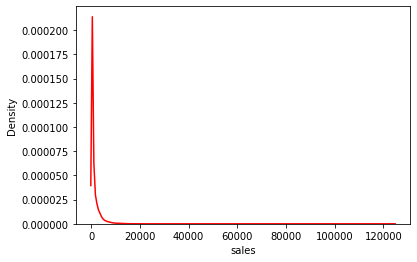

In [18]:
sns.kdeplot(df['sales'],color='r')

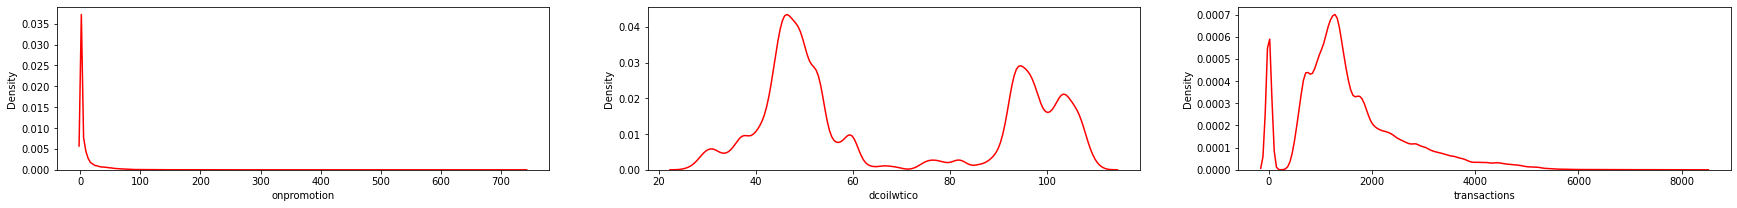

In [19]:
# distribution of continuous plots

#con_values.append('sales')


fig, axs = plt.subplots(ncols=len(con_values), nrows=1, figsize=(30, 3));
for x,j in zip(con_values,axs.ravel()):
  sns.kdeplot(df[x],ax=j,color='r')
  

Sales and on promotion is sharply rightly skewed. Similarly transactions are rightly skewed.
For oil prices we are seeing bimodal distribution

# **CONTINUOUS TO CONTINUOUS plots.**

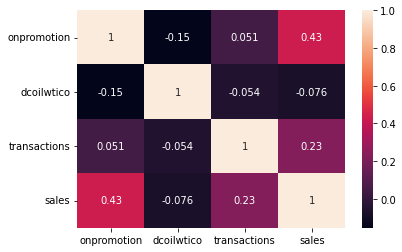

In [20]:
final = con_values+target
sns.heatmap(df[final].corr(),annot=True)

### **OIL PRICE VS SALES**

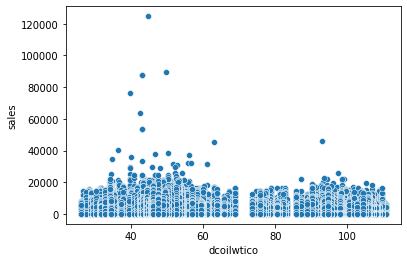

In [21]:
# Continuous vs continuous

sns.scatterplot(x=df['dcoilwtico'],y=df['sales'])

### **PROMOTION VS SALES**

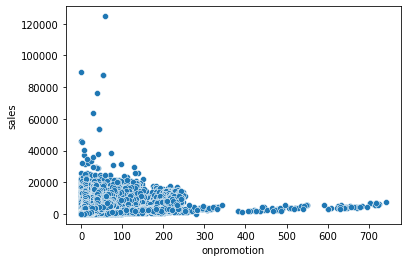

In [22]:
# Continuous vs continuous

sns.scatterplot(x=df['onpromotion'],y=df['sales'])

### **TRANSACTION VS SALES**

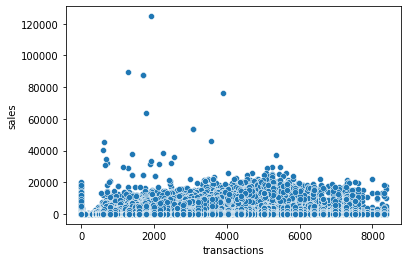

In [23]:
# Continuous vs continuous
sns.scatterplot(x=df['transactions'],y=df['sales'])

# **Category vs target**
'type_x','locale','locale_name','transferred','type_y','cluster']

### **HOLIDAY TYPE vs SALES**

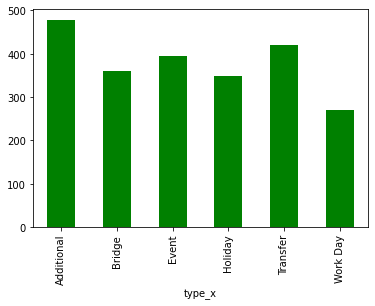

In [24]:
# tYPE OF HOLIDAY
df.groupby(['type_x'])['sales'].mean().plot(kind='bar',color='g')

### **HOLIDAY LOCALE vs SALES**

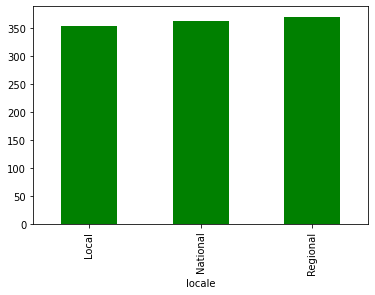

In [25]:
#sales
df.groupby(['locale'])['sales'].mean().plot(kind='bar',color='g')

### **REGION vs SALES**

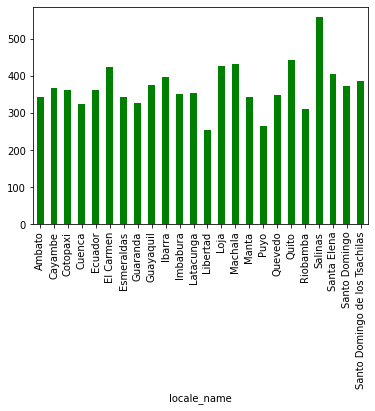

In [26]:
#locale_name
df.groupby(['locale_name'])['sales'].mean().plot(kind='bar',color='g')

### **CITY vs SALES**

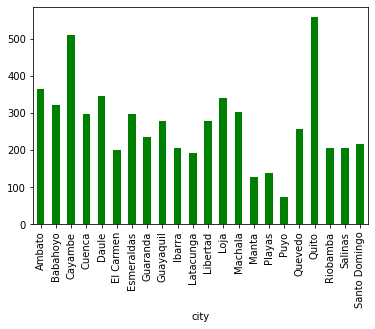

In [27]:
#locale_name
df.groupby(['city'])['sales'].mean().plot(kind='bar',color='g')

### **STATE vs SALES**

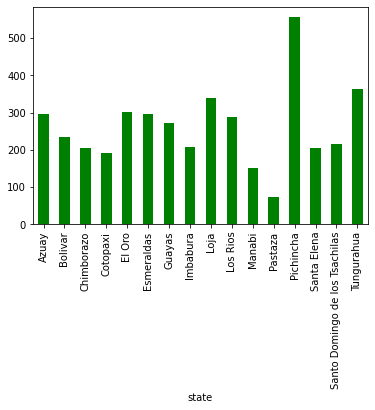

In [28]:
#locale_name
df.groupby(['state'])['sales'].mean().plot(kind='bar',color='g')

### **FAMILY vs SALES**

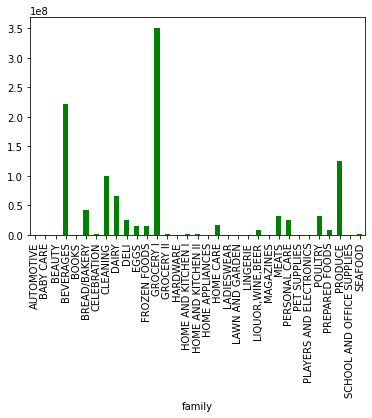

In [29]:
#locale_name
df.groupby(['family'])['sales'].sum().plot(kind='bar',color='g')

### **FAMILY vs PROMOTION**

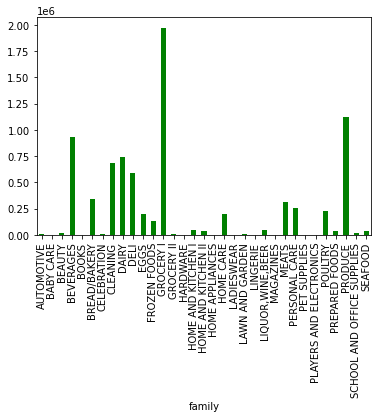

In [30]:
#locale_name
df.groupby(['family'])['onpromotion'].sum().plot(kind='bar',color='g')

### **TYPE_Y vs SALES**

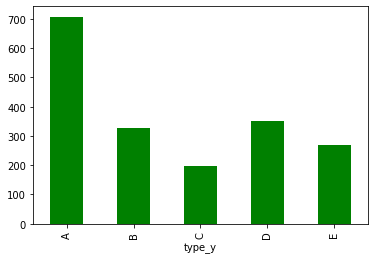

In [31]:
#sales
df.groupby(['type_y'])['sales'].mean().plot(kind='bar',color='g')

### **CLUSTER (Similar stores) vs SALES**

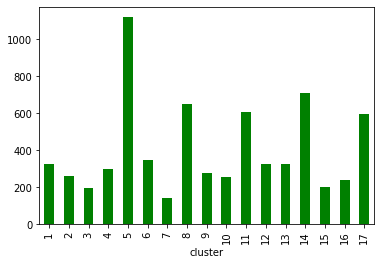

In [32]:
#sales
df.groupby(['cluster'])['sales'].mean().plot(kind='bar',color='g')

# **MULTI-LEVEL EDA**

# **TIME SERIES EDA**

## Average sales per day

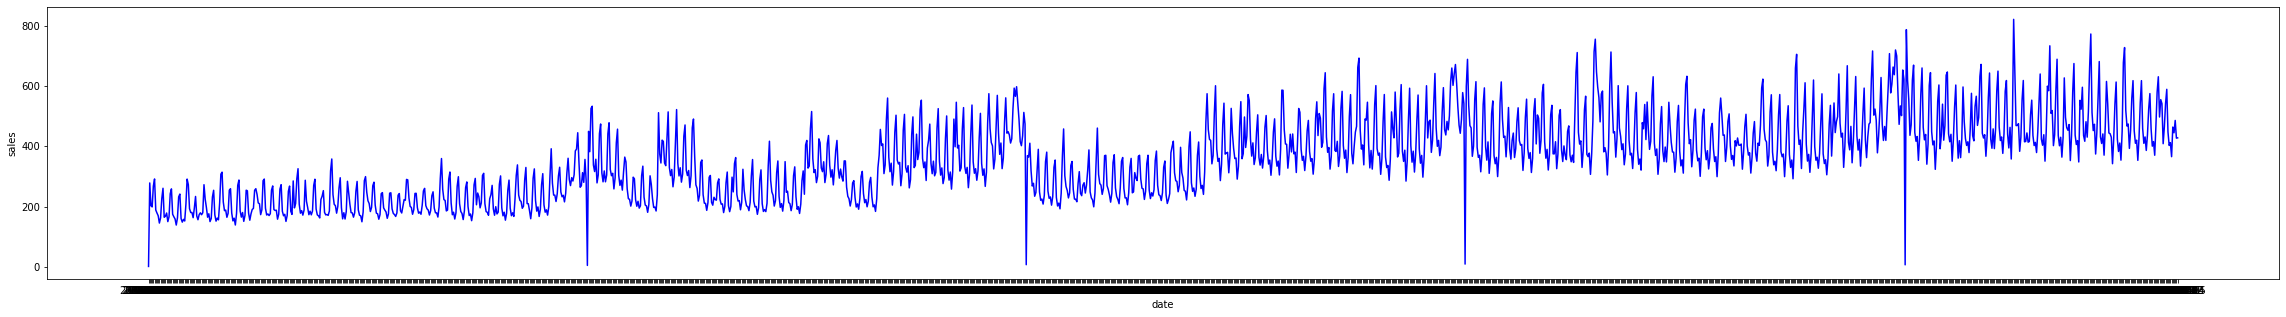

In [34]:
plt.figure(figsize=(40,5))
train_aux = df[['date', 'sales', 'onpromotion']].groupby('date').mean()
train_aux = train_aux.reset_index()
sns.lineplot(x=train_aux['date'],y=train_aux['sales'], color='blue')


The sales are on the rise. The trend has been consistent over the last two years (since July 2015). (almost stationary TS). Zooming in reveals that there is a seasonality every 7 days, with the same pattern (during the weekends higher sales). Sundays and Saturdays are the busiest days of the week.


## Average Sales by year, month, date

In [35]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.strftime("%B")
df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()

In [36]:

df_year_s = df.groupby('year').mean()[['sales']]
df_year_s = df_year_s.reset_index()
df_year_s['color'] =['rgb(210, 251, 212)', 'rgb(165, 219,194)', 'rgb(123,188, 176)', 'rgb(85, 156,158)', 'rgb(58,124, 137)']

df_month_s = df.groupby('month').mean()[['sales']]
df_month_s = df_month_s.sort_values('sales', ascending=True)
df_month_s['color'] = ['#bfbf40','#abab39','#989833','#85852c','#727226','#5f5f20','#5f5f20','#4c4c19','#393913','#26260c','#131306','#000000']
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month_s = df_month_s.reindex(new_order, axis=0)
df_month_s = df_month_s.reset_index()


df_day_of_week_s = df.groupby('day_of_week').mean()[['sales']]
df_day_of_week_s = df_day_of_week_s.sort_values('sales', ascending=False)
df_day_of_week_s['color'] = ['rgb(255, 0, 0)','rgb(255, 36, 36)','rgb(255, 71, 71)','rgb(255, 107, 107)','rgb(255, 143, 143)','rgb(255, 179, 179)','rgb(255, 214, 214)']
new_order_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_day_of_week_s = df_day_of_week_s.reindex(new_order_week, axis=0)
df_day_of_week_s = df_day_of_week_s.reset_index()

In [37]:
df_year = df.groupby('year').mean()[['onpromotion']]
df_year = df_year.reset_index()
df_year['color'] =['rgb(210, 251, 212)', 'rgb(165, 219,194)', 'rgb(123,188, 176)', 'rgb(85, 156,158)', 'rgb(58,124, 137)']



df_month = df.groupby('month').mean()[['onpromotion']]
df_month = df_month.sort_values('onpromotion', ascending=True)
df_month['color'] = ['#bfbf40','#abab39','#989833','#85852c','#727226','#5f5f20','#5f5f20','#4c4c19','#393913','#26260c','#131306','#000000']
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_month = df_month.reindex(new_order, axis=0)
df_month = df_month.reset_index()


df_day_of_week = df.groupby('day_of_week').mean()[['onpromotion']]
df_day_of_week = df_day_of_week.sort_values('onpromotion', ascending=False)
df_day_of_week['color'] = ['rgb(255, 0, 0)','rgb(255, 36, 36)','rgb(255, 71, 71)','rgb(255, 107, 107)','rgb(255, 143, 143)','rgb(255, 179, 179)','rgb(255, 214, 214)']
new_order_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_day_of_week = df_day_of_week.reindex(new_order_week, axis=0)
df_day_of_week = df_day_of_week.reset_index()

In [38]:
fig = make_subplots(rows=3, cols=2, 
                    subplot_titles=("Avg Sales by Year", "Avg On Promotion by Year", "Avg Sales by Month",
                                   "Avg On Promotion by MOnth", "Avg Sales by Day of Week", "Avg On Promotion by Day of Week"))
#SALES 
fig.append_trace(go.Bar(x=df_year_s['year'], y=df_year_s['sales'], marker = {'color': list(df_year_s['color'])}),
                row=1, col=1)


fig.append_trace(go.Bar(x=df_month_s['month'], y=df_month_s['sales'], marker = {'color': list(df_month_s['color'])}), 
                 row=2, col=1)

fig.append_trace(go.Bar(x=df_day_of_week_s['day_of_week'], y=df_day_of_week_s['sales'], marker = {'color': list(df_day_of_week_s['color'])}), row=3, col=1)

##ONPROMOTION
fig.append_trace(go.Bar(x=df_year['year'], y=df_year['onpromotion'], marker = {'color': list(df_year['color'])}),
                row=1, col=2)


fig.append_trace(go.Bar(x=df_month['month'], y=df_month['onpromotion'], marker = {'color': list(df_month['color'])}), 
                 row=2, col=2)

fig.append_trace(go.Bar(x=df_day_of_week['day_of_week'], y=df_day_of_week['onpromotion'],
                        marker = {'color': list(df_day_of_week['color'])}), row=3, col=2)
#styling
#fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
#fig.update_xaxes(visible=False, row=1, col=1)

fig.update_layout(height=1000, width=1000, title_text="AVERAGE SALES & ONPROMOTION ANALYSIS",  
                  title_font=dict(size=30, color='#8a8d93'), showlegend=False)

fig.show()

* There's an increasing trend in sales every year. It probably has to do with the decrease in oil prices (as it gives more purchasing power to consumers) or with growing econonmic conditions of Ecuador.
December is the month with the highst average units sold (Christmas is in December).
* During the weekends customers purchase more compared to week days.

* There has been an exponential increase in teh promotions trhoughout the years. No promotions in 2013.

* Highest promotions are during summer (June, July) and December (Christmas).
* Altough the highest sale son Sunday, the highest promotions are on Wednesdays and Fridays.

## AVERAGE SALES BY LOCATION

In [39]:
# Creating a dataframe with the city and sales
df_c_s = df.groupby('city').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_c_s['sales'] = round(df_c_s['sales'],2)

# Now for the state
df_st_s = df.groupby('state').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_st_s['sales'] = round(df_st_s['sales'],2)

# Product family
df_f_s = df.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_f_s['sales'] = round(df_f_s['sales'],2)

# For oil in order to see if oil price affects sales or not
df_o_s = df.groupby('dcoilwtico').agg({"sales" : "mean"}).reset_index()
df_o_s['sales'] = round(df_o_s['sales'],2)

sizeref = 2.*max(df_o_s['sales'])/(30**2)

# Colors for the graphs
df_c_s['color'] = ["#440154","#471365","#482374","#46327e","#424086","#3d4e8a","#365c8d","#31688e","#2c738e","#277f8e","#238a8d","#1f968b","#1fa187","#26ad81","#35b779","#4ac16d","#65cb5e","#81d34d","#a0da39","#c0df25","#dfe318","#fde725"]
df_st_s['color'] = ["#002051","#022c65","#14386d","#2b446e","#42506e","#575c6e","#696970","#787573","#868276","#948f78","#a49d78","#b6ab73","#caba6a","#e0c95d","#f2d950","#fdea45"]
df_f_s['color'] = ["#0b090a","#161a1d","#660708","#a4161a","#ba181b","#e5383b","#b1a7a6","#d3d3d3","#f5f3f4","#ffffff"]

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"},{"type": "bar"} ],
                           [{"type": "bar"}, {"type": "scatter"}]],
                    subplot_titles=("Avg Sales by State", "Avg Sales by City", "Avg Sales by Product Family", "Sales by Oil Price"))


fig.append_trace(go.Bar(x=df_st_s['state'], y=df_st_s['sales'],textposition='auto',text=df_st_s['sales'], marker = {'color': list(df_st_s['color'])}),
                row=1, col=1)
fig.append_trace(go.Bar(x=df_c_s['city'], y=df_c_s['sales'],textposition='auto',text=df_c_s['sales'], marker = {'color': list(df_c_s['color'])}),
                row=1, col=2)
fig.append_trace(go.Bar(x=df_f_s['family'], y=df_f_s['sales'],textposition='auto',text=df_f_s['sales'], marker = {'color': list(df_f_s['color'])}),
                row=2, col=1)
fig.append_trace(go.Scatter(x = df_o_s['dcoilwtico'], y = df_o_s['sales'],  mode = 'markers' , hovertemplate="<b>Oil_Price: %{x}<br><br><br>" + "<b>Sales: %{y}<br><br><br>", marker = dict(color = df_o_s['sales'],
                          colorscale = 'portland',opacity = 0.8,
                          sizemode = 'area', sizeref= sizeref,
                          sizemin= 4, showscale = False)), row=2, col=2)

fig.update_xaxes(title_text="Oil_Price", row=2, col=2)
fig.update_yaxes(title_text="Sales", row=2, col=2)
fig.update_layout(height=800, width=1400, title_text="AVG SALES 2",  
                  title_font=dict(size=40, color='#8a8d93'), showlegend=False)

fig.show()

## **STORE LEVEL SALES**

In [40]:


# Create a dataframe for city sales to assist in our plotting
df_cs_s = df.groupby('city').agg({"sales" : "sum"}).reset_index().sort_values(by='sales', ascending=False)
df_cs_s['sales'] = round(df_cs_s['sales'],2)

# Now for the stores
df_store_s = df.groupby(['city', 'family']).agg({"store_nbr" : "nunique"}).reset_index().sort_values(by='store_nbr', ascending=False)

# Now for the promotions
df_op_s = df.groupby(['city']).agg(sales_mean = ('sales', 'mean'), onpromotion_mean = ('onpromotion', 'mean')).reset_index().sort_values(by='sales_mean', ascending=False)
df_op_s['sales_mean'] = round(df_op_s['sales_mean'],2)
sizeref2 = 2.*max(df_op_s['sales_mean'])*100


fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"type": "bar"},{"type": "bar"} ],
                           [{"type": "bar"}, {"type": "scatter"}]],
                    subplot_titles=("Total Sales by State", "Total stores in City", "Average Items on Promotion"))


fig.append_trace(go.Bar(x=df_cs_s['city'], y=df_cs_s['sales'],textposition='auto',text=df_cs_s['sales'], marker = {'color': list(df_c_s['color'])}),
                row=1, col=1)
fig.append_trace(go.Bar(x=df_store_s['city'], y=df_store_s['store_nbr'],textposition='auto',text=df_store_s['store_nbr'], marker = {'color': list(df_st_s['color'])}),
                row=1, col=2)
fig.append_trace(go.Scatter(x = df_op_s['sales_mean'], y = df_op_s['onpromotion_mean'],  mode = 'markers+text' , text = df_op_s['city'],textposition='top center', marker = dict(color = df_op_s['sales_mean'],
                          colorscale = 'YlOrRd',opacity = 0.8,
                          sizemode = 'area', size = df_op_s['sales_mean'],
                          sizemin= 4, showscale = False)), row=2, col=1)
fig.update_layout(template="ggplot2",height=1000, width=1400, title_text="Total Sales by State, Store numbers and Average Items on Promotion",  
                  title_font=dict(size=40, color='#8a8d93'), showlegend=False)


fig.show()

We can see that indeed Guayaquil has more total sales than Cayambe but it is still quite underwhelming when looking at the big picture.
We also see that Guayaquil is the second city with the most stores with a total of 8 but still 10 less stores than Quito which has 18 in total
We see that Cayambe has the highest average of items in promotion which probably help it become the second highest in average sales

## SEASONALITY PATTERN IN TIME SERIES DAY WISE, MONTH WISE



In [41]:
df_sesonality = df.copy()

df_sesonality = df_sesonality.groupby('date').mean()[['sales']].reset_index()
#create month and year variables from date colum
df_sesonality['date'] = pd.to_datetime(df_sesonality['date'])
df_sesonality['year'] = df_sesonality['date'].dt.year
df_sesonality['month'] = df_sesonality['date'].dt.month
df_sesonality['weekofyear'] = df_sesonality['date'].dt.weekofyear
df_sesonality['day'] = df_sesonality['date'].dt.day
df_sesonality['dayofweek'] = df_sesonality['date'].dt.day_name()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Sales')

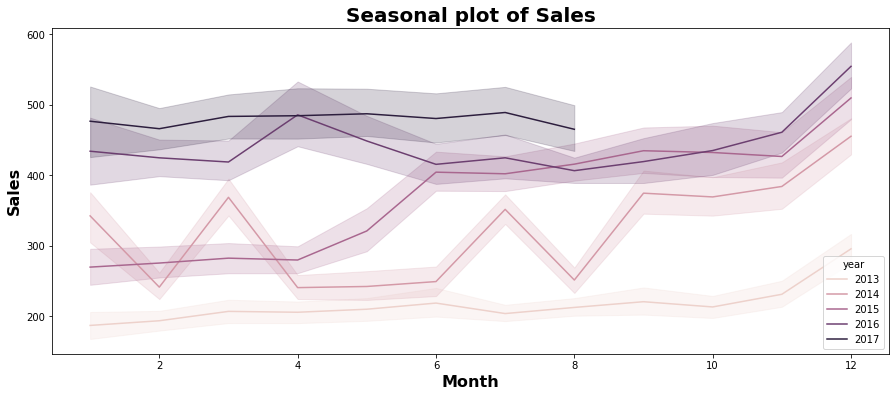

In [42]:
variable = 'sales'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
sns.lineplot(df_sesonality['month'], df_sesonality[variable], hue=df_sesonality['year'])
ax.set_title('Seasonal plot of Sales', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales', fontsize = 16, fontdict=dict(weight='bold'))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Sales')

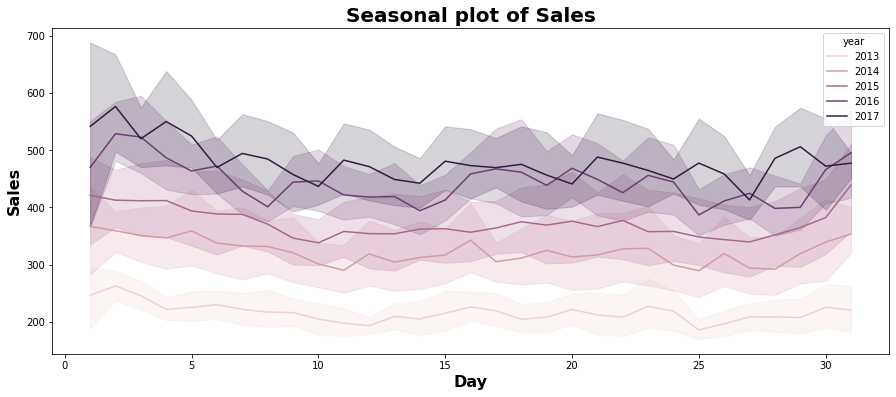

In [43]:
variable = 'sales'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 10)
sns.lineplot(df_sesonality['day'], df_sesonality[variable], hue=df_sesonality['year'])
ax.set_title('Seasonal plot of Sales', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Day', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Sales', fontsize = 16, fontdict=dict(weight='bold'))




```

```

## **STORE LEVEL ANALYSIS AND VECTOR ARIMA USING PYTHON**

Chosen store:
23,37,41,44,51



In [44]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 49.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import  MinMaxScaler

# EXTRACT STORE 10 LEVEL DATA

In [46]:
i = 9

sales_promo = df[df['store_nbr']==(i+1)].groupby(['date'])['sales','onpromotion'].agg('sum')
oil_price = df[df['store_nbr']==(i+1)].groupby(['date'])['dcoilwtico'].agg('median')
df["holiday_cat"] = df[df['store_nbr']==(i+1)]['transferred'] == False

holiday_update = df[df['store_nbr']==(i+1)].groupby(['date'])['holiday_cat'].agg('max')
  
transactions = df[df['store_nbr']==(i+1)].groupby(['date'])['transactions'].agg('mean')
cluster_n = df[df['store_nbr']==(i+1)].groupby(['date'])['cluster'].agg('median')
#   file_name = '/content/drive/MyDrive/store-sales-time-series-forecasting/Updated/'+'store'+str(i+1)+'.csv'
x = pd.DataFrame()
x['sales'] = sales_promo['sales']
x['promo'] = sales_promo['onpromotion']
x['oil price'] = oil_price
x['Holiday'] = holiday_update
x['transactions'] = transactions
x['cluster']  = cluster_n

size = int(len(x)*0.8)
train = x.iloc[:size,:]
test = x.iloc[size:,:]
  # Filling null values using backfilling
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
  
TEST_SIZE = test.shape[0]
 
x.reset_index(inplace=True)
x['Data_O'] =  pd.to_datetime(x['date'])



# Perform AD fuller test to confirm on stationarity
# Adfuller test results
result = sts.adfuller(x['sales'])
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 




  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



ADF Statistic: -5.456788463827466
n_lags: 2.571049810023308e-06
p-value: 2.571049810023308e-06
Critial Values:
   1%, -3.4342930672797065
Critial Values:
   5%, -2.8632816397229064
Critial Values:
   10%, -2.567697207194407


# LAGGING PLOTS

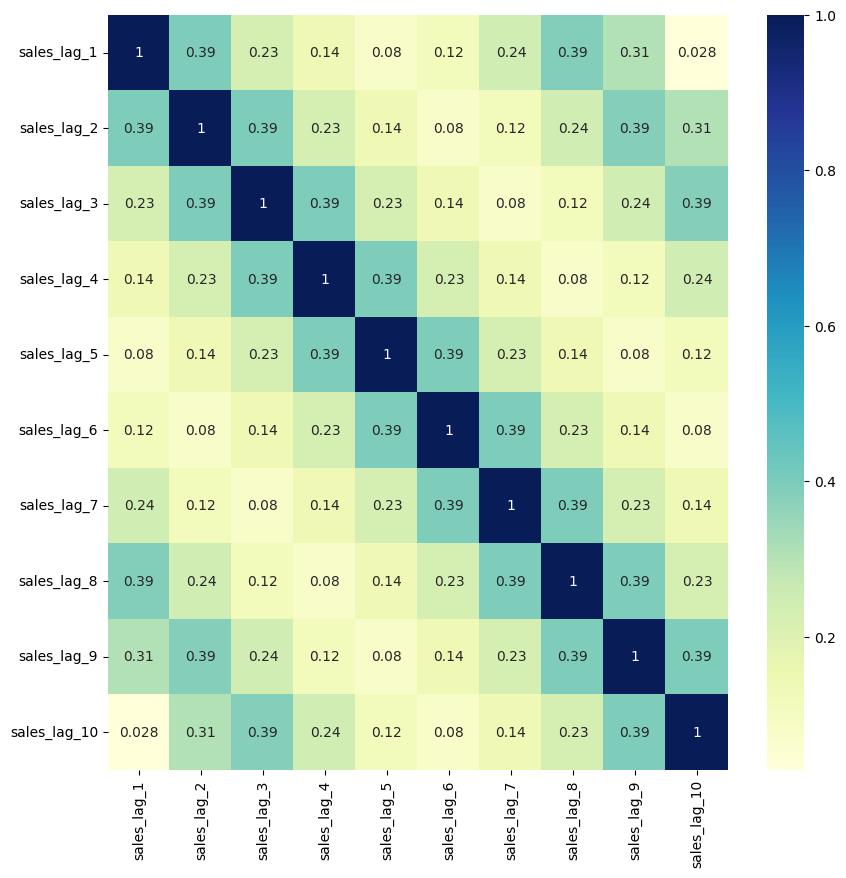

In [47]:
plt.figure(figsize=(10,10), dpi=100)
LAGS = [1,2,3,4,5,6,7,8,9,10]

df_lag = x.copy()
for lag in LAGS:
    df_lag[f"sales_lag_{lag}"] = df_lag['sales'].transform(lambda x: x.shift(lag))

df_lag_corr = df_lag[[col for col in list(df_lag.columns) if col.startswith('sales_')]]

sns.heatmap(df_lag_corr.corr(), annot=True, cmap="YlGnBu")
plt.show()

This is lag plot we plotted this to see if values in a dataset or time series are random. Here we see non-random structure. We can see a linear pattern, which implies the need to AR model

Small prices 7 days ago and consecutive days sales are influenced current days sales. the highest correlation of 0.39 was observed every consecutive day and once every 8 days. No correlation is observed after every 5, 10 days.


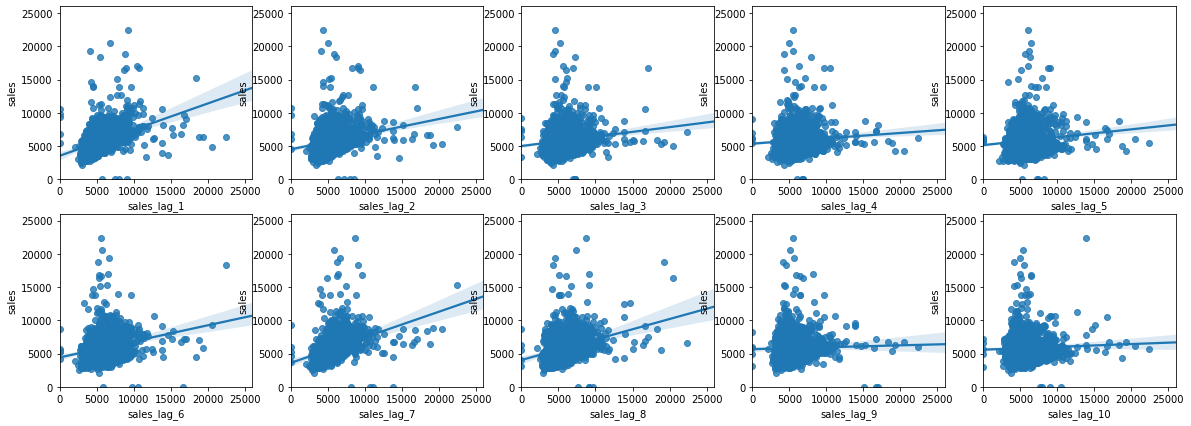

In [48]:
xlim = (0, 26000)
ylim = (0, 26000)

df_aux = df_lag.copy()
fig, axes = plt.subplots(2, 5, figsize=(20,7))
axes[0,0].set_xlim(xlim)
axes[0,0].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_1", y="sales", ax=axes[0,0])
axes[0,1].set_xlim(xlim)
axes[0,1].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_2", y="sales",  ax=axes[0,1])
axes[0,2].set_xlim(xlim)
axes[0,2].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_3", y="sales",  ax=axes[0,2])
axes[0,3].set_xlim(xlim)
axes[0,3].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_4", y="sales",  ax=axes[0,3])
axes[0,4].set_xlim(xlim)
axes[0,4].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_5", y="sales",  ax=axes[0,4])
###
axes[1,0].set_xlim(xlim)
axes[1,0].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_6", y="sales",  ax=axes[1,0])
axes[1,1].set_xlim(xlim)
axes[1,1].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_7", y="sales",  ax=axes[1,1])
axes[1,2].set_xlim(xlim)
axes[1,2].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_8", y="sales",  ax=axes[1,2])
axes[1,3].set_xlim(xlim)
axes[1,3].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_9", y="sales",  ax=axes[1,3])
axes[1,4].set_xlim(xlim)
axes[1,4].set_ylim(ylim)
sns.regplot(data=df_aux, x="sales_lag_10", y="sales",  ax=axes[1,4])

# TIME SERIES PLOT OF STORE 10

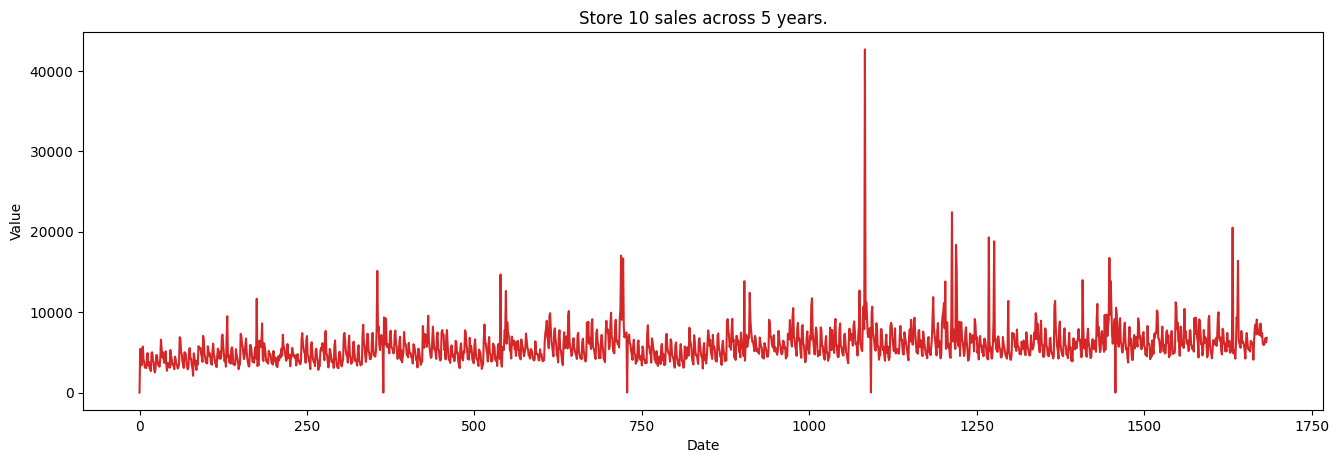

In [49]:

df=x.copy()

def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.sales, title='Store 10 sales across 5 years.')  

# SEASONAL DECOMPOSITION

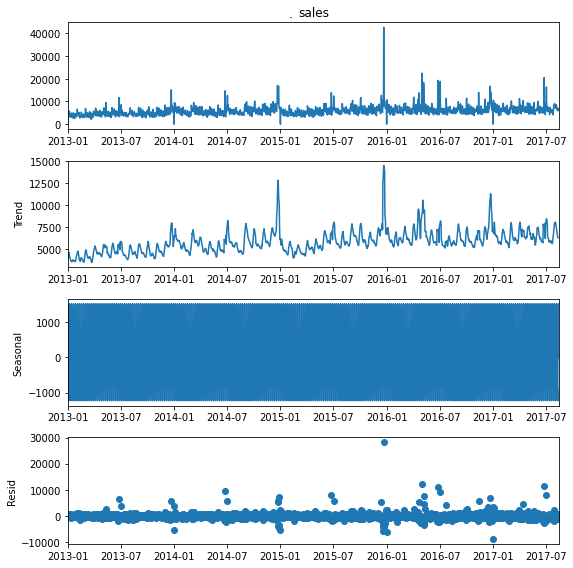

In [50]:
#plt.figure(figsize=(40,5))
#s_dec_addtive = seasonal_decompose(x.sales,model="additive")
#s_dec_addtive.plot()
#plt.xticks(rotation = 90)
df2 = df.copy()

df2.set_index('Data_O',inplace=True)

df3 =  df2.asfreq('d')



df3.fillna(method='bfill',axis=0,inplace=True)


result_add = seasonal_decompose(df3['sales'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_add.plot().suptitle('.')
plt.show()


## DETEND AND DESEASONLIZE TIME SERIES TO ENSURE STATIONARITY

Text(0.5, 1.0, 'Sales Volume detrended by subtracting the trend component')

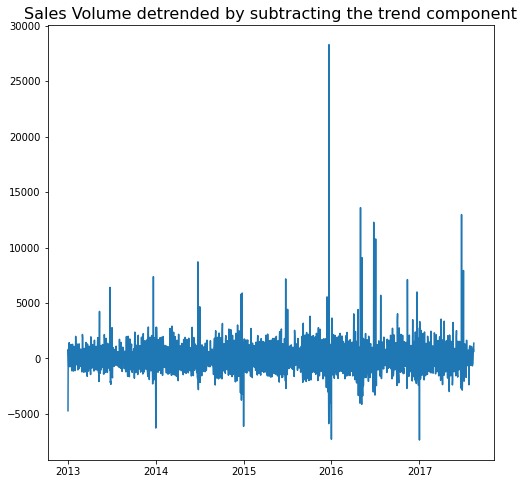

In [51]:
# Detrend time series
df4 = df.copy()
result_mul = seasonal_decompose(df3['sales'], model='additive', extrapolate_trend='freq')
detrended = df3.sales.values - result_mul.trend
plt.plot(detrended)
plt.title('Sales Volume detrended by subtracting the trend component', fontsize=16)

- 1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.

- 2. Seasonal difference the series (subtract the value of previous season from the current value)

- 3. Divide the series by the seasonal index obtained from STL decomposition

[]

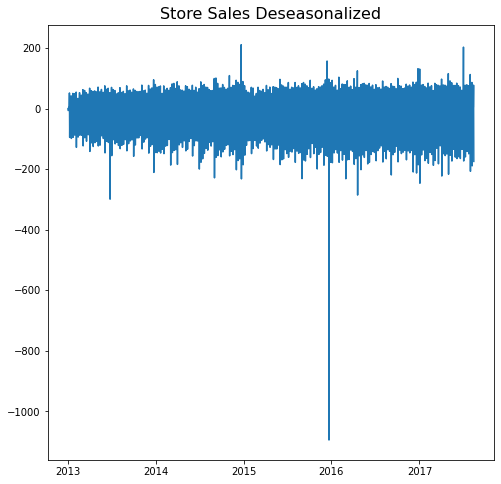

In [52]:

# Time Series Decomposition
result_mul = seasonal_decompose(df3['sales'], model='additive', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df3.sales.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Store Sales Deseasonalized', fontsize=16)
plt.plot()

## CAUSALITY TEST

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

x_gc = x.copy()

x_gc.drop(['date','Data_O','cluster'],inplace=True,axis=1)

data = np.asarray(x_gc[['sales','Holiday']])

#gc_res = grangercausalitytests(data, 20)


from statsmodels.tsa.stattools import grangercausalitytests

maxlag=20
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

print(grangers_causation_matrix(x_gc, variables = x_gc.columns))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 7, but rank is 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 14, but rank is 1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWar

                sales_x  promo_x  oil price_x  Holiday_x  transactions_x
sales_y         1.00000  0.00000      0.00000    0.13720         0.00000
promo_y         0.00000  1.00000      0.00000    0.00140         0.00000
oil price_y     0.58630  0.18970      1.00000    0.49910         0.09430
Holiday_y       0.00320  0.00460      0.12950    1.00000         0.01890
transactions_y  0.00000  0.00000      0.00000    0.00720         1.00000


We observed oil price is have poor significance in influencing  any other series.

## ACF & PACF

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



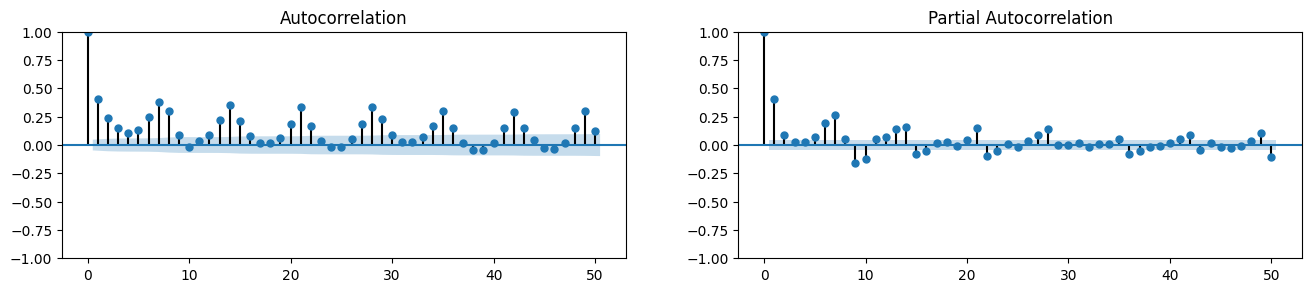

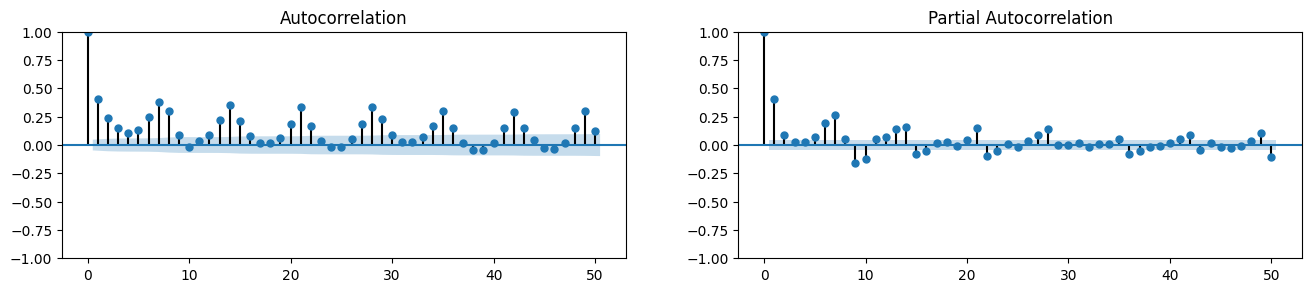

In [56]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df3.sales.tolist(), lags=50, ax=axes[0])
plot_pacf(df3.sales.tolist(), lags=50, ax=axes[1])

Similar conclusion of seasonality in steps of 7 can be arrived from ACF PLOT
Coming to PACF we know PACF cancels out all additional channels a previous lag period affects the present one. We are seeing negative value at lag period 9 which implies higher sales values 9 days ago will cause lower values today


## MODELING

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros 

RMSE:  2006.2164512073705


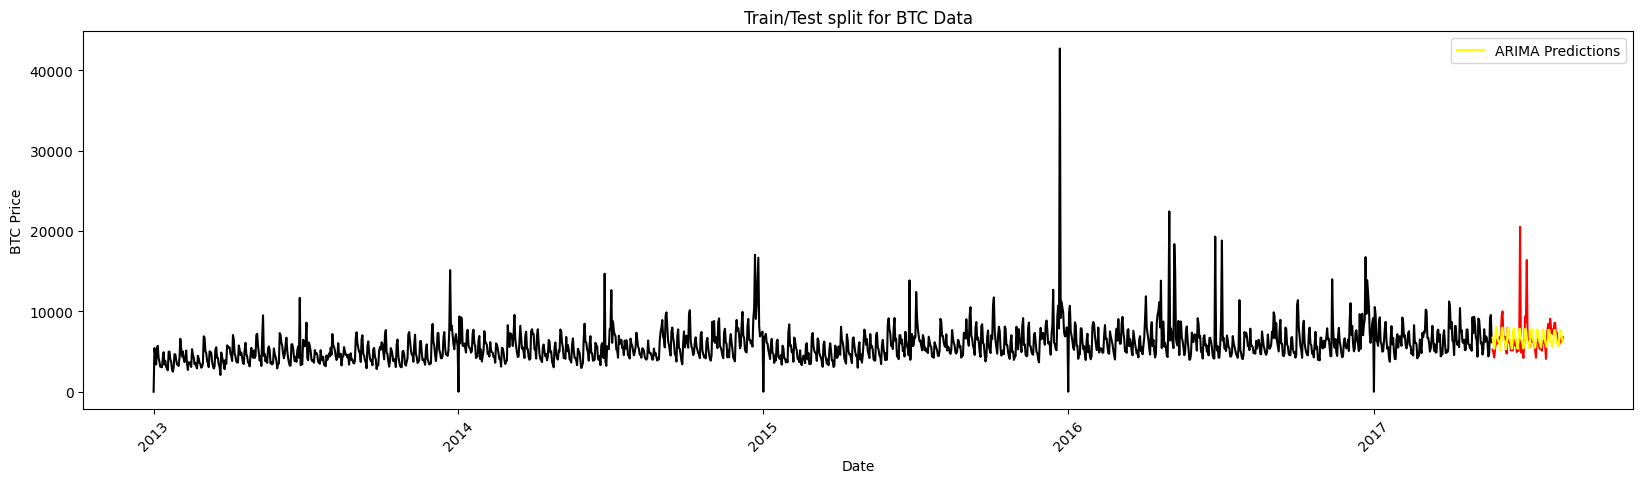

In [66]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error


size = int(len(x)*0.95)
train = x.iloc[:size,:]
test = x.iloc[size:,:]

train.set_index('Data_O',inplace=True)
test.set_index('Data_O',inplace=True)


plt.figure(figsize=(20,5), dpi=100)
plt.plot(train.sales, color = "black")
plt.plot(test.sales, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")

y = train.sales



ARIMAmodel = ARIMA(y, order = (10 ,1,10))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["sales"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)




In [71]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


print("MAPE:",mape(test['sales'], y_pred_df["Predictions"]))

MAPE: 14.694111262084405


In [73]:
from sklearn.metrics import r2_score
print("RMSE",r2_score(test['sales'], y_pred_df["Predictions"]))

RMSE 0.19159062020799067


## VECTOR ARIMA

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
var_model = VARMAX(train,order=(4,0),enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                                  Statespace Model Results                                                 
Dep. Variable:     ['sales', 'promo', 'oil price', 'transactions', 'Holiday_True']   No. Observations:                 1347
Model:                                                                      VAR(4)   Log Likelihood              -27401.730
                                                                       + intercept   AIC                          55043.460
Date:                                                             Mon, 15 Aug 2022   BIC                          55668.136
Time:                                                                     04:19:16   HQIC                         55277.427
Sample:                                                                          0                                         
                                                                            - 1347                                         
Covarian